<a href="https://colab.research.google.com/github/AmiraFaisal/Scenario2/blob/main/Figuring%20out%20splits_Scenario_2_t5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[google doc](https://docs.google.com/document/d/1AJEu1s_ViChkY-IaLYIUC7Ia_XehJ62D9Er2ykEBsMs/edit?usp=drive_link)

# **1. Data Exploration and Preprocessing**

## **a. Load and explore**
the MedQuAD dataset to understand its structure and content.

### Set up libraries, dataset

49s

In [ ]:
pip install wordcloud matplotlib langchain langchain-text-splitters chromadb datasets sentence-transformers transformers accelerate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.7 MB/s eta

26s

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pprint
import chromadb
import torch
import random
import traceback

52s

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from langchain_text_splitters import RecursiveCharacterTextSplitter
from hashlib import md5
from datasets import Dataset, DatasetDict
from sklearn.metrics.pairwise import cosine_similarity
from transformers import(
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    GenerationConfig,
    EarlyStoppingCallback,
    AutoModelForSequenceClassification,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer)

In [ ]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1)

### xx

In [ ]:
url = "https://raw.githubusercontent.com/AmiraFaisal/Scenario2/main/MedQuAD_Dataset_RAG_Scenario_2.csv"
df = pd.read_csv(url, header = 0)
df.head()

,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question    16412 non-null  object
 1   answer      16407 non-null  object
 2   source      16412 non-null  object
 3   focus_area  16398 non-null  object
dtypes: object(4)
memory usage: 513.0+ KB


In [ ]:
def get_column_stats(dataframe):
    """Calculates Min, Max, and Average for all columns."""
    stats = {}

    for col in dataframe.columns:
        series = dataframe[col]

        if pd.api.types.is_numeric_dtype(series):
            # Numeric columns: calculate stats on the values
            stats[col] = {
                'Type': 'Numeric',
                'Min': series.min(),
                'Max': series.max(),
                'Average': series.mean(),
            }

        elif pd.api.types.is_string_dtype(series) or series.dtype == 'object':
            # String/Object columns: calculate stats on the string length
            lengths = series.astype(str).str.len()

            stats[col] = {
                'Type': 'String/Text',
                'Min Length': lengths.min(),
                'Max Length': lengths.max(),
                'Average Length': lengths.mean(),
            }

        else:
            stats[col] = {'Type': str(series.dtype), 'Note': 'Stats not calculated'}

    # Convert the results dictionary into a readable DataFrame
    return pd.DataFrame(stats).T.round(2)

# Run the function on the sample DataFrame
summary_df = get_column_stats(df)

print("--- Comprehensive Column Stats Summary ---")
print(summary_df)
print("-" * 30)

--- Comprehensive Column Stats Summary ---
                   Type Min Length Max Length Average Length
question    String/Text         16        191      50.684438
answer      String/Text          3      29046    1300.793992
source      String/Text          3         17       5.340239
focus_area  String/Text          3        136      26.225018
------------------------------


In [ ]:
def filterByLength(df: pd.DataFrame, column_name: str, min_length: int) -> pd.DataFrame:
    """
    Returns a new DataFrame with rows removed where the specified column's
    string length is less than the minimum length threshold.

    Returns:
        pd.DataFrame: A new DataFrame containing only the rows that meet the length criteria.
    """

    print(f"--- Filtering '{column_name}': Removing rows with length < {min_length} ---")

    # 1. Safely calculate the length of every cell (converting to string first)
    string_lengths = df[column_name].astype(str).str.len()

    # 2. Create a boolean mask: True where length is >= min_length
    complete_mask = string_lengths >= min_length

    # 3. Filter the DataFrame and return the result
    return df[complete_mask].copy() # Use .copy() to ensure a new DataFrame is returned

# --- Example Usage (Assuming 'df' is loaded) ---
# df = pd.DataFrame(...)

# Clean 'question' column
print(f"Original Row Count: {len(df)}")
df = filterByLength(
    df=df,
    column_name='question',
    min_length=20
)
print(f"Row Count after 'question' filter: {len(df)}")


# Clean 'answer' column
df = filterByLength(
    df=df,
    column_name='answer',
    min_length=20
)
print(f"Row Count after 'answer' filter: {len(df)}")
print("-" * 55)

Original Row Count: 16412
--- Filtering 'question': Removing rows with length < 20 ---
Row Count after 'question' filter: 16399
--- Filtering 'answer': Removing rows with length < 20 ---
Row Count after 'answer' filter: 16356
-------------------------------------------------------


### Downsampling `focus_area`

In [ ]:
# Unique 'focus_area's or Medical Topics
unique_focus_areas = df['focus_area'].astype(str).unique()
print(len(unique_focus_areas), "unique Focus Areas")

5124 unique Focus Areas


In [ ]:
focus_area_counts = df['focus_area'].value_counts()

In [ ]:
# Table summary of Focus area distribution
groups = pd.cut(focus_area_counts,
                bins = [0, 4, 20, float('inf')],
                labels = ['<5', '5 - 20', '>20'])
summary_focus_area = groups.value_counts().sort_index().to_frame(name = 'focus_area')
summary_focus_area['%'] = (summary_focus_area['focus_area'] / summary_focus_area['focus_area'].sum()) * 100
summary_focus_area['%'] = summary_focus_area['%'].map('{:.1f}%'. format)
summary_focus_area

,focus_area,%
count,,
<5,3388,66.1%
5 - 20,1719,33.6%
>20,16,0.3%


In [ ]:
# Only use counts >10 and then top 1000 focus areas
above10counts_index = focus_area_counts[focus_area_counts > 10].index
above10counts = focus_area_counts[above10counts_index]
top1000 = above10counts.head(1000)

# cap at max 20 counts per focus area
new = pd.DataFrame()
for f_a in top1000.index:
    fa_df = df[df['focus_area'] == f_a]
    sample = fa_df.sample(n = min(20, len(fa_df)))
    new = pd.concat([new, sample])

print("Original df shape:", df.shape)
print("After cleaning   :", new.shape)

Original df shape: (16356, 4)
After cleaning   : (1406, 4)


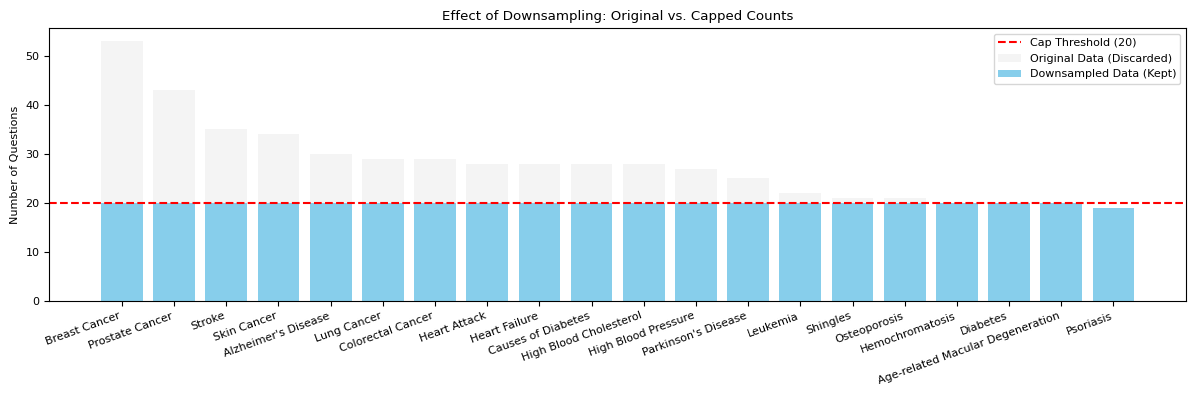

In [ ]:
sampled_counts = new['focus_area'].value_counts()

# Select top 20 focus areas from the ORIGINAL data to visualize
top_areas = focus_area_counts.head(20).index

# Align both datasets to these top 20
original_vals = focus_area_counts.loc[top_areas]
sampled_vals = sampled_counts.reindex(top_areas, fill_value=0)

plt.figure(figsize=(12, 4))

# Plot Original Data (The "Shadow")
plt.bar(top_areas, original_vals, color='gainsboro', alpha=0.3, label='Original Data (Discarded)')

# Plot Sampled Data (The "Result")
plt.bar(top_areas, sampled_vals, color='skyblue', alpha=1.0, label='Downsampled Data (Kept)')

plt.axhline(y=20, color='red', linestyle='--', label='Cap Threshold (20)')

plt.xticks(rotation=20, ha = 'right', fontsize = 8)
plt.title('Effect of Downsampling: Original vs. Capped Counts')
plt.ylabel('Number of Questions')
plt.legend()
plt.tight_layout()
plt.show()

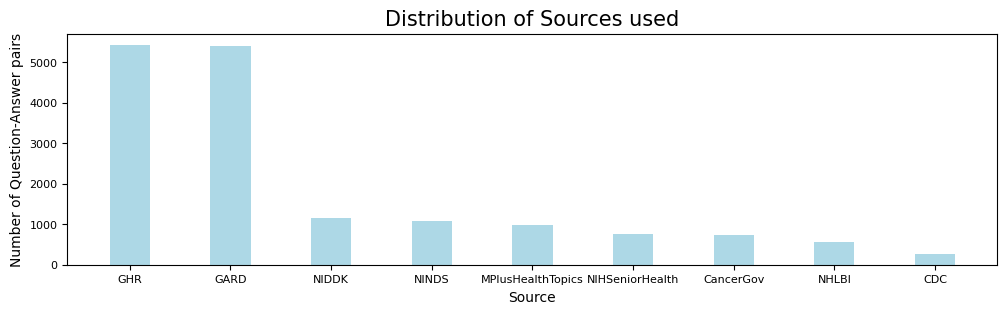

9 Sources used:  ['CDC', 'CancerGov', 'GARD', 'GHR', 'MPlusHealthTopics', 'NHLBI', 'NIDDK', 'NIHSeniorHealth', 'NINDS']


In [ ]:
# After downsampling
# Bar Chart
source_counts = df['source'].value_counts()

plt.figure(figsize=(12, 3))
plt.rcParams.update({'font.size': 8})
plt.bar(source_counts.index, source_counts.values, color='lightblue', width=0.4)
plt.xlabel("Source", fontsize=10)
plt.ylabel("Number of Question-Answer pairs", fontsize=10)
plt.title("Distribution of Sources used", fontsize=15)
plt.show()

# Unique 'source's
unique_sources = df['source'].unique()
print(len(unique_sources), "Sources used: ", sorted(unique_sources))

NIHSeniorHealth is majority, so assume **audience for QA is the elderly**, as stated on their website, "NIA provides health information informed by research and reviewed by experts to help you learn about healthy aging and common health conditions in older adults."

In [ ]:
# Sources for Top 10 Focus Areas

In [ ]:
df = new.copy()

### Length Distributions, QA relation, WordCloud

In [ ]:
word_count_question = df['question'].apply(lambda x: len(x.split(' ')) + 1)
word_count_answer = df['answer'].apply(lambda x: len(str(x).split(' ')) + 1)

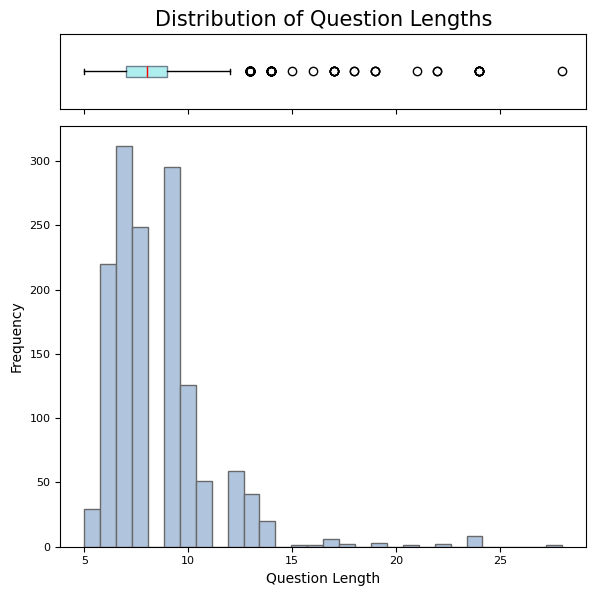

In [ ]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(6, 6))
# Box plot
ax_box.boxplot(word_count_question, vert=False, patch_artist=True,
               boxprops=dict(facecolor='paleturquoise', color='slategray'),
               medianprops=dict(color='red'))
ax_box.set_ylabel('')
ax_box.set_yticks([])
ax_box.set_title('Distribution of Question Lengths', fontsize=15)

# Histogram on the bottom subplot
ax_hist.hist(word_count_question, bins=30, color='lightsteelblue', edgecolor='dimgrey')
ax_hist.set_xlabel('Question Length', fontsize=10)
ax_hist.set_ylabel('Frequency', fontsize=10)

fig.tight_layout() # Remove extra space between subplots
ax_box.set(xlabel='') # Remove x axis name for the boxplot
plt.show()

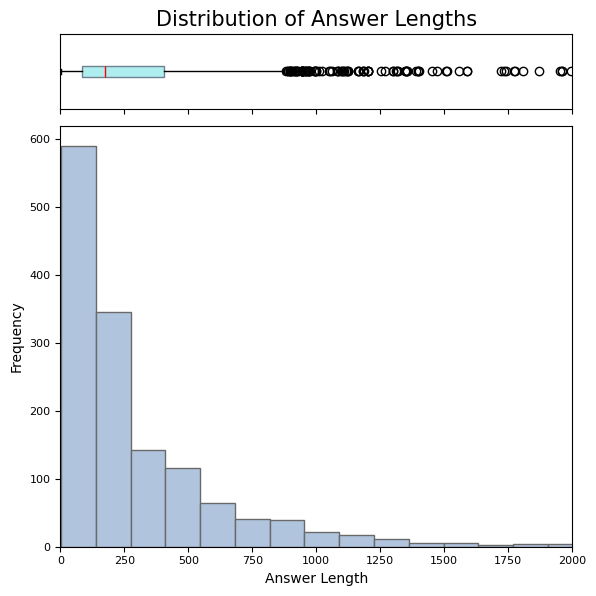

In [ ]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(6, 6))
# Box plot
ax_box.boxplot(word_count_answer, vert=False, patch_artist=True,
               boxprops=dict(facecolor='paleturquoise', color='slategray'),
               medianprops=dict(color='red'))
ax_box.set_ylabel('')
ax_box.set_yticks([])
ax_box.set_title('Distribution of Answer Lengths', fontsize=15)

# Histogram on the bottom subplot
ax_hist.hist(word_count_answer, bins=30, color='lightsteelblue', edgecolor='dimgrey')
ax_hist.set_xlabel('Answer Length', fontsize=10)
ax_hist.set_ylabel('Frequency', fontsize=10)

ax_hist.set_xlim(0,2000)

fig.tight_layout() # Remove extra space between subplots
ax_box.set(xlabel='') # Remove x axis name for the boxplot
plt.show()

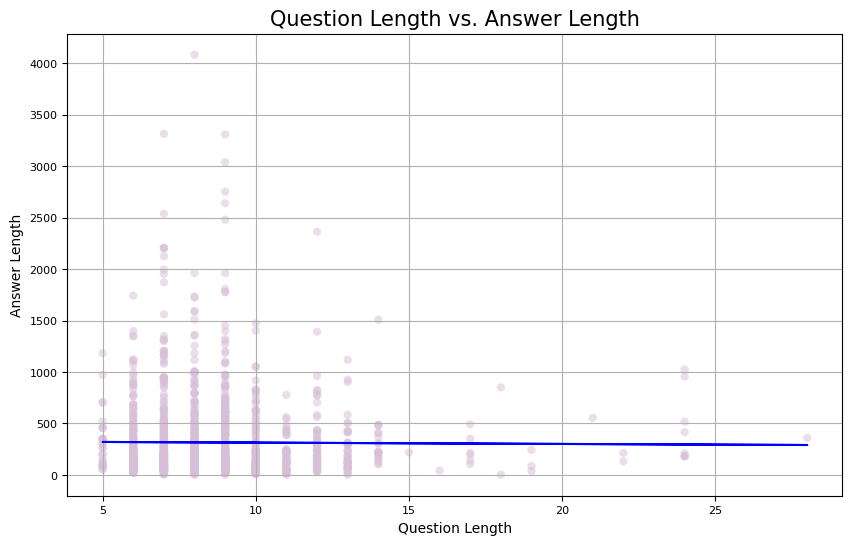

The gradient of the straight line is: -1.2930


In [ ]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(word_count_question, word_count_answer, alpha=0.5, edgecolors='none', color='thistle')

# Calculate equation for trendline
z = np.polyfit(word_count_question, word_count_answer, 1)
p = np.poly1d(z)
ax.plot(word_count_question, p(word_count_question), color='blue')

ax.set_xlabel('Question Length', fontsize=10)
ax.set_ylabel('Answer Length', fontsize=10)
ax.set_title('Question Length vs. Answer Length', fontsize=15)

ax.grid(True)
plt.show()

z = np.polyfit(word_count_question, word_count_answer, 1)
print(f"The gradient of the straight line is: {z[0]:.4f}")

Every 1-word increase in *Question length*, increases *Answer length* by ~6.48 words.

Question key words reveal a trend on chronic diseases or major health conditions (e.g. x, y, z)

Most questions seek definitions to medical conditions, as well as asking the cause or symptoms. Consequently, there is strong interest in treatment information.

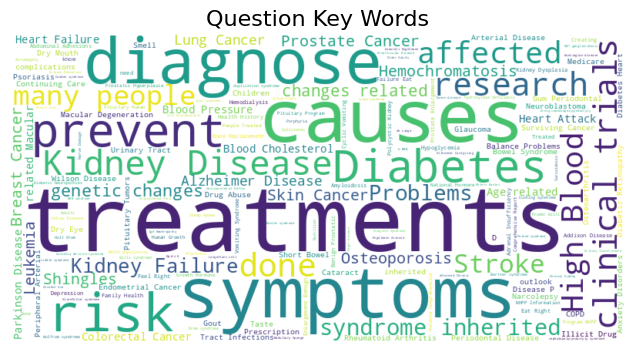

In [ ]:
question_text = ' '.join(df['question'].astype(str))
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      stopwords=STOPWORDS,
                      colormap='viridis').generate(question_text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Hide axes
plt.title("Question Key Words", fontsize=16)
plt.show()

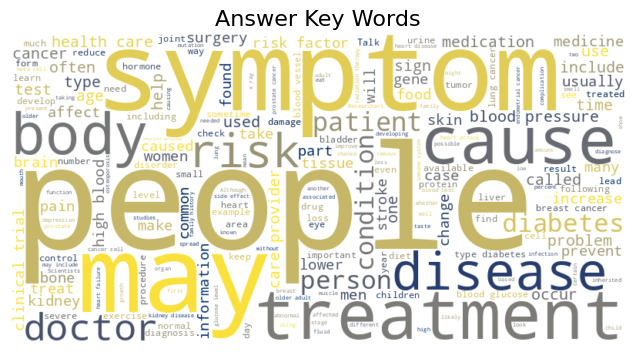

In [ ]:
question_text = ' '.join(df['answer'].astype(str))
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      stopwords=STOPWORDS,
                      colormap='cividis').generate(question_text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Hide axes
plt.title("Answer Key Words", fontsize=16)
plt.show()

## **b. Prepare the data**



### Duplicates - part 1

Set up needed functions

In [ ]:
def normalize_text(text):
    """
    Aggressive normalization for duplicate detection.
    Removes all extra spaces, punctuation variations, etc.
    """
    if not isinstance(text, str): return ""

    text = text.lower() # Lowercase
    text = re.sub(r'\s+', ' ', text) # Remove all extra whitespace (spaces, tabs, newlines)
    text = text.strip() # Remove leading/trailing spaces

    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)

    return text

def hashing(df):
    """Create hash for Q&A pairs to detect duplicates.
       Returns: DataFrame with new 'qa_hash' column
    """
    # Normalize for Q and A fields using earlier 'normalize_text' function
    q_norm = df['question'].apply(normalize_text)
    a_norm = df['answer'].apply(normalize_text)

    # Combine normalized Q&A
    qa_norm = q_norm + '|||' + a_norm

    # Create 16 digit hash
    df['qa_hash'] = qa_norm.apply(lambda x: md5(x.encode()).hexdigest())

    return df

def identify_duplicates(df):
    """Search for same hashes and report back
       Returns: Index of duplicate hashes, d_df
    """
    qa_hash = df['qa_hash']

    # Find which hashes appear more than once
    hash_counts = qa_hash.value_counts()
    d_hashes = hash_counts[hash_counts > 1].index

    print(f"Of {len(df)} pairs, {qa_hash.nunique()} unique hashes were created")
    print(f"Duplicate groups found: {len(d_hashes)}")
    print(f"Total duplicate pairs: {hash_counts[d_hashes].sum()}")

    # Create d_df to store duplicated pairs
    d_df = df[qa_hash.isin(d_hashes)].copy()

    # Group duplicates using ids
    hash_groups = {hash_val: i for i, hash_val in enumerate(d_hashes)}
    d_df['duplicate group'] = d_df['qa_hash'].map(hash_groups)
    d_df = d_df.sort_values('duplicate group')

    return d_hashes, d_df

def remove_duplicates(df):
    """
    Returns: clean_df, d_df
    """
    d_hashes, d_df = identify_duplicates(df)

    # Remove duplicates
    clean_df = df.drop_duplicates(subset = 'qa_hash', keep = 'first').copy()

    # Remove temporary fields
    clean_df = clean_df.drop(['qa_hash'], axis=1)
    d_df = d_df.drop(['qa_hash'], axis=1)

    print(f"After removing duplicates: {len(clean_df)} pairs")
    print(f"Removed: {len(df) - len(clean_df)} pairs\n")

    return clean_df, d_df

def truncate(text, length_limit):
    """Truncate text to `length_limit` characters."""
    return f"{text[:length_limit]}{'...' if len(text) > length_limit else ''}"

def show_duplicates(df, max_groups = 10):
    """Show grouped duplicates
    """
    clean_df, d_df = remove_duplicates(df)

    if d_df is None:
        print("No duplicates found")
        return
    d_groups = d_df.groupby('duplicate group')
    print(f"{' '*21} Showing {max_groups} duplicate groups")
    d_pairs = list(d_groups)[:max_groups]
    for i, g in d_pairs:
        print(f"{'='*70}")
        print(f"{' '*22} GROUP {i+1} with {len(g)} occurrences")
        print(f"{'='*70}")

        p_ids = []
        for index, (pair_idx, pair) in enumerate(g.iterrows(),1):
            p_ids.append(f"Row {pair_idx}")
        print(", ". join(p_ids))

        pair = g.iloc[0]
        print("The duplicated QA pair")
        print(f"    Question: {truncate(pair['question'], 100)}")
        print(f"    Answer  : {truncate(pair['answer'], 60)}")
        print(f"    Focus Area: {pair['focus_area']}")

### Duplicates - part 2

duplicates in answer field

In [ ]:
# Hash Q&A pairs
df = hashing(df)

# Review found duplicates
show_duplicates(df, max_groups = 10)

Of 1406 pairs, 1377 unique hashes were created
Duplicate groups found: 21
Total duplicate pairs: 50
After removing duplicates: 1377 pairs
Removed: 29 pairs

                      Showing 10 duplicate groups
                       GROUP 1 with 6 occurrences
Row 15248, Row 15347, Row 15346, Row 15247, Row 16019, Row 16209
The duplicated QA pair
    Question: What causes Causes of Diabetes ?
    Answer  : Other types of diabetes have a variety of possible causes.
 ...
    Focus Area: Causes of Diabetes
                       GROUP 2 with 4 occurrences
Row 15249, Row 16021, Row 16211, Row 15348
The duplicated QA pair
    Question: What to do for Causes of Diabetes ?
    Answer  : - Diabetes is a complex group of diseases with a variety of ...
    Focus Area: Causes of Diabetes
                       GROUP 3 with 3 occurrences
Row 16017, Row 15245, Row 15344
The duplicated QA pair
    Question: What causes Causes of Diabetes ?
    Answer  : Type 2 diabetesthe most common form of diabetesis 

In [ ]:
# Remove duplicates
clean_df, d_df = remove_duplicates(df)

Of 1406 pairs, 1377 unique hashes were created
Duplicate groups found: 21
Total duplicate pairs: 50
After removing duplicates: 1377 pairs
Removed: 29 pairs



In [ ]:
df = clean_df

One of the primary advantages of using cryptographic hashing in data deduplication is its ability to quickly determine unique data segments. By generating a hash for each piece of data, systems can compare hash values rather than the actual data. If two data segments produce the same hash, they can be identified as duplicates. This method significantly reduces the time and resources required for data comparison, as comparing hash values is computationally less intensive than comparing full data sets.

### Clean `answer` field

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
oridf=df.copy()

In [ ]:
df = oridf.copy()

In [ ]:
column_name = 'answer'
threshold = 20
print(f"--- Results: Rows where length of '{column_name}' < {threshold} ---")
# Use iterrows() to loop over each row of the DataFrame
for index, row in df.iterrows():
    # 1. Get the value from the specified column for the current row
    answer_value = row[column_name]
    # 2. Convert to string to handle potential NaN values and check the length
    value_length = len(str(answer_value))
    # 3. Apply the condition
    if value_length < threshold:
        # Print the index, the value, and its length
        print(f"Index: **{index}**, Value: '{answer_value}', Length: **{value_length}**")
print("-" * 30)

--- Results: Rows where length of 'answer' < 20 ---
------------------------------


In [ ]:
def clean_references(text):

    if not isinstance(text, str):
        return ""

    # lowercasing
    text = text.lower()

    phone_pattern = r'\b\d{3}-\d{3}-\d{4}\b|\b\d{3}-\d{2}-\d{4}\b|\b1-\d{3}-\d{3}-\d{4}\b|\b\d{4}-\d{3}-\d{4}\b|\bToll Free:.*?\b'
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    address_pattern = r'\d+\s+[A-Za-z\s]+,\s*[A-Za-z\s]+,\s*[A-Z]{2}\s*\d{5}(-\d{4})?'

    # remove patterns
    text = re.sub(phone_pattern, '', text, flags=re.IGNORECASE)
    text = re.sub(email_pattern, '', text)
    text = re.sub(url_pattern, '', text)
    text = re.sub(address_pattern, '', text)

    ref_keywords = ['toll free', 'phone', 'email',
                    'fax', 'tty', 'clearinghouse',
                    'esc', 'keyboard', 'video',
                    'for more information', 'glossary',
                    'learn more', 'www']

    # Split by sentence-ending punctuation followed by space
    sentences = re.split(r'(?<=[.!?])\s+', text)

    # if sentence has no ref_keywords, then save to cleaned_sentences
    cleaned_sentences = [s for s in sentences if not any(keyword in s.lower() for keyword in ref_keywords)]
    cleaned_text = '. '.join(cleaned_sentences).strip()

    # Replace whitespace characters with a single space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

    # If sentence starts with . then remove the .
    cleaned_text = re.sub(r'^\s*\.\s*', '', cleaned_text)
    return cleaned_text

df_answer = df['answer'].apply(clean_references)

In [ ]:
print("Before: ", df['answer'][0])
print("After: ", df_answer[0])
df['answer'] = df_answer
# Remove rows where the answer field is empty or only whitespace
df = df[df['answer'].str.strip() != '']

# Reset index
df = df.reset_index(drop=True)

Before:  Breast cancer affects one in eight women during their lives. Breast cancer kills more women in the United States than any cancer except lung cancer. No one knows why some women get breast cancer, but there are a number of risk factors. Risks that you cannot change include       - Age - the chance of getting breast cancer rises as a woman gets older     - Genes - there are two genes, BRCA1 and BRCA2, that greatly increase the risk. Women who have family members with breast or ovarian cancer may wish to be tested.     - Personal factors - beginning periods before age 12 or going through menopause after age 55       Other risks include being overweight, using hormone replacement therapy (also called menopausal hormone therapy), taking birth control pills, drinking alcohol, not having children or having your first child after age 35 or having dense breasts.    Symptoms of breast cancer may include a lump in the breast, a change in size or shape of the breast or discharge from a ni

In [ ]:
check befiore after changing index reset

In [ ]:
# After cleaning, Run the function on the sample DataFrame
summary_df = get_column_stats(df)

print("--- Comprehensive Column Stats Summary ---")
print(summary_df)
print("-" * 30)

--- Comprehensive Column Stats Summary ---
                   Type Min Length Max Length Average Length
question    String/Text         20        191      42.524088
answer      String/Text         49      18099    1553.967153
source      String/Text          3         17       9.751825
focus_area  String/Text          4        136      19.941606
------------------------------


### Split datasets for fine-tuning and testing

to be then train and validate the LLM

In [ ]:
train_data, valtest = train_test_split(
    df,
    test_size = 0.30, # 40% for test + val
    stratify = df['focus_area'],
    random_state = 1)

val_data, test_data = train_test_split(
    valtest,
    test_size = 0.30, # split the remaining
    stratify =  valtest['focus_area'],
    random_state = 1)

print("Training data shape  : ", train_data.shape)
print("Validation data shape: ", val_data.shape)
print("Test data shape      : ", test_data.shape)

Training data shape  :  (959, 4)
Validation data shape:  (287, 4)
Test data shape      :  (124, 4)


### Create chunks

In [ ]:
# Calculate actual token counts
question_tokens = [len(tokenizer.encode(q)) for q in df['question']]
answer_tokens = [len(tokenizer.encode(a)) for a in df['answer'] ]

combined_tokens = [q + a for q, a in zip(question_tokens, answer_tokens)]

print(f"Avg question tokens: {sum(question_tokens)/len(question_tokens)}")
print(f"Avg answer tokens: {sum(answer_tokens)/len(answer_tokens)}")
print(f"Avg combined tokens: {sum(combined_tokens)/len(combined_tokens)}")
print(f"95th percentile answer tokens: {sorted(answer_tokens)[int(len(answer_tokens)*0.95)]}")

Token indices sequence length is longer than the specified maximum sequence length for this model (1183 > 512). Running this sequence through the model will result in indexing errors


Avg question tokens: 13.607299270072993
Avg answer tokens: 372.2744525547445
Avg combined tokens: 385.8817518248175
95th percentile answer tokens: 1206


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
splitter = RecursiveCharacterTextSplitter(
    chunk_size=350,
    chunk_overlap=50,
    length_function=lambda x: len(tokenizer.encode(x)),
)

# Get the longest answers by character length
longest_answers_train = train_data.assign(answer_len=train_data['answer'].str.len()).nlargest(3, 'answer_len')['answer'].tolist()
longest_answers_val = val_data.assign(answer_len=val_data['answer'].str.len()).nlargest(3, 'answer_len')['answer'].tolist()
longest_answers_test = test_data.assign(answer_len=test_data['answer'].str.len()).nlargest(3, 'answer_len')['answer'].tolist()

test_answers = longest_answers_train + longest_answers_val + longest_answers_test

for answer in test_answers:
    chunks = splitter.split_text(answer)
    for chunk in chunks:
        tokens = len(tokenizer.encode(chunk))
        print(f"Chunk: {tokens} tokens")

Chunk: 149 tokens
Chunk: 136 tokens
Chunk: 130 tokens
Chunk: 140 tokens
Chunk: 149 tokens
Chunk: 156 tokens
Chunk: 152 tokens
Chunk: 156 tokens
Chunk: 142 tokens
Chunk: 136 tokens
Chunk: 144 tokens
Chunk: 158 tokens
Chunk: 144 tokens
Chunk: 158 tokens
Chunk: 167 tokens
Chunk: 139 tokens
Chunk: 136 tokens
Chunk: 154 tokens
Chunk: 159 tokens
Chunk: 160 tokens
Chunk: 148 tokens
Chunk: 131 tokens
Chunk: 132 tokens
Chunk: 136 tokens
Chunk: 149 tokens
Chunk: 148 tokens
Chunk: 154 tokens
Chunk: 148 tokens
Chunk: 148 tokens
Chunk: 152 tokens
Chunk: 150 tokens
Chunk: 148 tokens
Chunk: 46 tokens
Chunk: 143 tokens
Chunk: 142 tokens
Chunk: 150 tokens
Chunk: 147 tokens
Chunk: 141 tokens
Chunk: 141 tokens
Chunk: 147 tokens
Chunk: 140 tokens
Chunk: 144 tokens
Chunk: 140 tokens
Chunk: 160 tokens
Chunk: 155 tokens
Chunk: 152 tokens
Chunk: 153 tokens
Chunk: 146 tokens
Chunk: 140 tokens
Chunk: 158 tokens
Chunk: 145 tokens
Chunk: 149 tokens
Chunk: 178 tokens
Chunk: 140 tokens
Chunk: 102 tokens
Chunk: 144 

In [ ]:
all_chunks = []

def create_chunks(dataframe, split_subset, start_counter):
    local_chunks = []
    current_counter = start_counter
    for i, row in dataframe.iterrows():
        answer_text = row['answer']
        q, a_sliced, focus, source = row['question'], answer_text, row['focus_area'], row['source']
        chunks = splitter.split_text(a_sliced)

        for chunk_local_id, chunk in enumerate(chunks):
            local_chunks.append({
                'question_id': current_counter,                    # New sequential ID
                'chunk_id': f"{current_counter}_{chunk_local_id}", # Unique ID based on new sequential ID
                'question': q,                                     # Original question
                'chunk_answer': chunk,                             # The actual split text
                'focus_area': focus,
                'source': source,
                'split_subset': split_subset                       # Add split subset information
            })
        current_counter += 1            # Increment the counter after processing all chunks for a question
    return local_chunks, current_counter


current_question_id_counter = 0

train_chunks, current_question_id_counter = create_chunks(train_data, 'train', current_question_id_counter)
val_chunks, current_question_id_counter = create_chunks(val_data, 'val', current_question_id_counter)
test_chunks, current_question_id_counter = create_chunks(test_data, 'test', current_question_id_counter)

all_chunks = train_chunks + val_chunks + test_chunks

print(f"Total chunks created: {len(all_chunks)}")
print(f"Total unique question_ids: {current_question_id_counter}")

Total chunks created: 4453
Total unique question_ids: 1370


In [ ]:
all_chunks[0]

{'question_id': 0,
 'chunk_id': '0_0',
 'question': 'What is (are) Amyloidosis and Kidney Disease ?',
 'chunk_answer': 'the kidneys are two bean-shaped organs, each about the size of a fist.. they are located just below the rib cage, one on each side of the spine.. every day, the two kidneys filter about 120 to 150 quarts of blood to produce about 1 to 2 quarts of urine, composed of wastes and extra fluid.. the urine flows from the kidneys to the bladder through tubes called ureters.. the bladder stores urine.. when the bladder empties, urine flows out of the body through a tube called the urethra, located at the bottom of the bladder.. in men, the urethra is',
 'focus_area': 'Amyloidosis and Kidney Disease',
 'source': 'NIDDK',
 'split_subset': 'train'}

### Create embeddings

convert each chunk into dense vector embeddings using `SentenceTransformer` model

In [ ]:
qa_pairs = []

length_limit = 300

for chunk_item in all_chunks:
    question = chunk_item.get('question', '')
    chunk_answer = chunk_item.get('chunk_answer', '')

    # Truncate if > 300 length for 'chunk_answer'
    if len(chunk_answer) > length_limit:
        truncated_answer = truncate(chunk_answer, length_limit)
    else:
        truncated_answer = chunk_answer

    # Embedding qa_pairs
    qa_pairs.append(f"{question} {truncated_answer}")

embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Create embeddings
embeddings = embed_model.encode(
    qa_pairs,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

In [ ]:
qa_pairs[0]

'What are the treatments for Osteoarthritis ? warm towels, hot packs, or a warm bath or shower can provide temporary pain relief..medications such as non-steroidal anti-inflammatory drugs, or nsaids, help reduce pain and inflammation that result from osteoarthritis..a doctor or physical therapist can recommend if heat or cold is the best'

In [ ]:
min(qa_pairs, key=len)

'What to do for Porphyria ? #name?'

In [ ]:
qa_pairs.index(min(qa_pairs, key=len))

4854

In [ ]:
qa_pairs[4854]

'What to do for Porphyria ? #name?'

In [ ]:
qa_pairs[4853]

'What is (are) Colorectal Cancer ? of antibody that researchers make in large amounts in a laboratory.'

In [ ]:
type(qa_pairs)

list

In [ ]:
{'question_id': 0,
 'chunk_id': '0_0',
 'question': 'QUESTION',
 'chunk_answer': 'XX',
 'focus_area': 'XX',
 'source': 'XX',
 'split_subset': 'train'}

### Chromadb vector store

In [ ]:
# Initialize ChromaDB
db_client = chromadb.PersistentClient(path="./MedQuAD_db")

# In case of duplicates from re-runs
try:
    db_client.delete_collection("medical_rag")
except:
    pass

vector_store = db_client.create_collection(name="medical_rag")

# Add to ChromaDB
vector_store.add(
    ids = [m['chunk_id'] for m in metadata],  # Use chunk_id as primary key
    embeddings = embeddings.tolist(),
    documents = qa_pairs,
    metadatas = metadata                                 # Previously defined
)

InternalError: ValueError: Batch size of 8327 is greater than max batch size of 5461

In [ ]:
vector_store.get(ids = ['0_0'])

In [ ]:
{'ids': ['0_0'],
 'embeddings': None,
 'documents': ['QUESTION? ANSWER'],
 'uris': None,
 'included': ['metadatas', 'documents'],
 'data': None,
 'metadatas': [{'question': 'QUESTION',
   'question_id': 0,
   'chunk_id': '0_0',
   'source': XX,
   'chunk_answer': XX,
   'split_subset': XX,
   'focus_area': XX }]}

In [ ]:
# Query ChromaDB
results = collection.query(
    query_texts = ["What is (are) Glaucoma ?"],
    n_results = 5
)

# Check id consistency
for i, (chunk_id, metadata) in enumerate(zip(results['ids'][0], results['metadatas'][0])):
    print(f"Result {i}:")
    print(f"  chunk_id: {chunk_id}")
    print(f"  question_id: {metadata['question_id']}")
    print(f"  question: {metadata['question']}")
    print(f"  split: {metadata['split_subset']}")
    print(f"  Can trace back: question_id {metadata['question_id']} → original train_data row\n")

Result 0:
  chunk_id: 356_1
  question_id: 356
  question: What is (are) Glaucoma ?
  split: train
  Can trace back: question_id 356 → original train_data row

Result 1:
  chunk_id: 1328_0
  question_id: 1328
  question: What is (are) Glaucoma ?
  split: test
  Can trace back: question_id 1328 → original train_data row

Result 2:
  chunk_id: 1023_0
  question_id: 1023
  question: What is (are) Glaucoma ?
  split: val
  Can trace back: question_id 1023 → original train_data row

Result 3:
  chunk_id: 356_0
  question_id: 356
  question: What is (are) Glaucoma ?
  split: train
  Can trace back: question_id 356 → original train_data row

Result 4:
  chunk_id: 1228_1
  question_id: 1228
  question: What is (are) Glaucoma ?
  split: val
  Can trace back: question_id 1228 → original train_data row



# **2. Implement a Retrieval-Augmented Generation (RAG):**

Uses a Retriever to embed and retrieve relevant document chunks,
and a Generator, which is a pretrained language model instructed to
answer based only on retrieved context.

## **Retriever**

**Retriever**: Responsible for finding relevant documents or passages from a knowledge base given a query.

### Rewrite query

Below is an instruction that describes a task, paired with an inpu that provides further context. Write a response that appropriately completes the request. Instruction: {You are a helpful medical practitioner}
Input:
{}
Response:
{}

In [ ]:
rewritter_llm = pipeline(
    "text2text-generation",
    model = "google/flan-t5-small",
    max_length = 64,
    do_sample = False,        # always chooses the most probable next word or token
    temperature = 0.3,        # more straightforward and predictable output
    repetition_penalty = 1.3, # minimize repetition and have a more varied output
    no_repeat_ngram_size = 2)

def rewrite_query(user_query):
    """ Rewrite the user query to be more specific, medical focused.
    Return rewritten query"""

    # few shot prompting
    prompt = f"""
    Rewrite Output 4 questions to be specific medical search queries.
    Input: my head hurts
    Output: What are the primary causes of headaches and severe migraines?

    Input: sugar levels too high
    Output: What are the clinical symptoms and management strategies for hyperglycemia?

    Input: is drug X safe for kids
    Output: What are the pediatric contraindications and safety guidelines for Drug X?

    Input: i keep vomitting but feel ok afterwards
    Output: What are the symptoms of Cyclic Vomiting Syndrome ?

    Input: {user_query}
    Output 4:
    """

    llm_output = rewritter_llm(prompt)

    rewritten_query = llm_output[0]['generated_text']
    rewritten_query = rewritten_query.replace("Output:", "").strip()

    return rewritten_query.strip()

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
# test
user_query = "What are the symptoms of Cyclic Vomiting Syndrome ?"
rewritten_query = rewrite_query(user_query)

print(f"Original: {user_query}")
print(f"Rewritten: {rewritten_query}")

Original: What are the symptoms of Cyclic Vomiting Syndrome ?
Rewritten: What are the symptoms of Cyclic Vomiting Syndrome ?


### Re-rank Contexts

In [ ]:
rerank_tokenizer = AutoTokenizer.from_pretrained("castorini/monot5-base-msmarco")
rerank_model = AutoModelForSeq2SeqLM.from_pretrained("castorini/monot5-base-msmarco")
rerank_model.eval() # Set to evaluation mode, w/o training

tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
def getMonoT5Scores(rewritten_query, chunks):
  """Calculate relevance scores aginst query
  Return list of scores `batch_scores`
  """
  # 1. Format the input "Query: ABC? Document: XYZ... Relevant: "
  inputs = [f"Query: {rewritten_query} Document: {c} Relevant:" for c in chunks]

  # 2. Tokenise
  tokenized_inputs = rerank_tokenizer(
      inputs,
      padding = True,
      truncation = True,      # Cut off if chunk is too long
      return_tensors = 'pt')  # Return as PyTorch tensors

  # 2. Generate predictions either True / False
  with torch.no_grad():                                       # w/o calculating gradients, and faster
    outputs = rerank_model.generate(
        input_ids = tokenized_inputs['input_ids'],
        attention_mask = tokenized_inputs['attention_mask'],
        max_new_tokens = 1,                                   # Only generate 1 token ("true" or "false")
        return_dict_in_generate = True,
        output_scores = True)                                 # Get probability scores, not just the token

    # 3. Extract scores
    true_token_id = rerank_tokenizer.encode("true")[0]
    batch_scores = outputs.scores[0][:, true_token_id]        # Get probability of "true"

    return batch_scores.tolist()

### Retrieve

In [ ]:
def retriever(q, top_k = 5, detail = False):
    """Retrieve context based on rewritten query
    Returns contexts"""

    # 1. Embed the rewritten query
    q_rewritten = rewrite_query(q) # Renamed to avoid confusion
    q_embed = embed_model.encode([q_rewritten]).tolist() # .tolist() because chromadb expects lists, not numpy arrays
    if not q_rewritten or q_rewritten.strip() == "":
        raise ValueError("Query rewrite returned empty string")

    # 2. Search for similar vectors in chromadb collection
    search_result = collection.query(
        query_embeddings = q_embed,
        n_results = max(5, top_k * 2))  # At least 10 or 2x what user wants
    if not search_result['documents'][0]:
        return []  # or raise exception

    # 3. Format search results
    retrieved_chunks = search_result['documents'][0]
    retrieved_metas = search_result['metadatas'][0]
    retrieved_ids = search_result['ids'][0] # Get the chunk_ids here
    retrieved_distances = search_result.get('distances', [[]])[0]

    # 4. Rerank
    rerank_scores = getMonoT5Scores(q_rewritten, retrieved_chunks) # Use q_rewritten here
    if len(rerank_scores) != len(retrieved_chunks):
        raise ValueError("Rerank scores mismatch chunk count")

    # 5. Map score with their data
    candidates = []
    for r in range(len(retrieved_chunks)):
      candidates.append({
        'chunk_id': retrieved_ids[r],
        'chunk_answer': retrieved_chunks[r],
        'question': retrieved_metas[r]['question'],
        'focus_area': retrieved_metas[r]['focus_area'],
        'chroma_dist': retrieved_distances[r],
        'rerank_score': rerank_scores[r]
      })

    # 6. Sort high to low scores
    candidates.sort(key = lambda s:s['rerank_score'], reverse = True)
    sorted_results = candidates[:top_k]

    # 7. Combine needed items into `contexts` dictionary
    contexts = []
    for i in sorted_results:
        item = {
            'chunk_id': i['chunk_id'], # Ensure chunk_id is always present
            'chunk_answer': i['chunk_answer'],
            'question': i['question']
        }
        if detail:
            item['focus_area'] = i['focus_area']
            item['rerank_score'] = round(i['rerank_score'], 3)
            item['chroma_distance'] = round(i['chroma_dist'], 3)
        contexts.append(item)

    return contexts

## **Augmenter**

In [ ]:
# --- load model
flant5tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
flant5model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

### Build Prompt

In [ ]:
def build_prompt(user_query, context, rewritten_query, max_tokens = 512):
    """Build prompt with token limit
    Returns prompt text for the generator"""

    if not context:
        return f"""I don't have relevant medical information to answer this question.
                Question: {rewritten_query}
                Answer: I couldn't find relevant information in my knowledge base."""

    instruction_text = f"""Use the following medical contexts to answer the question.
    Contexts:
    """
    query_footer = f"\n\nQuestion: {rewritten_query}\nAnswer:"

    # 4. Calculate "Static Overhead"
    # We use add_special_tokens=False to avoid adding <s> or [CLS] multiple times
    inst_tokens = len(flant5tokenizer.encode(instruction_text, add_special_tokens=False))
    query_tokens = len(flant5tokenizer.encode(query_footer, add_special_tokens=False))

    # Reserve a tiny safety margin (e.g., 5 tokens) for joiner newlines
    total_static_cost = inst_tokens + query_tokens + 5

    # 5. Calculate remaining budget for context
    remaining_tokens = max_tokens - total_static_cost

    if remaining_tokens < 0:
        print("Query and Instructions are larger than max_tokens limit!")
        # You might want to truncate the query here if it's massive
        remaining_tokens = 0

    # 6. Fill the context budget
    valid_contexts = []
    current_context_tokens = 0

    for idx, c in enumerate(context, start=1):
        # Format the individual chunk
        chunk_text = f"[C{idx}] Q: {c['question']}\nA: {c['chunk_answer']}"

        # Count tokens for this specific chunk
        chunk_len = len(flant5tokenizer.encode(chunk_text, add_special_tokens=False))

        # Check if adding this chunk exceeds the remaining budget
        if current_context_tokens + chunk_len > remaining_tokens:
            print(f"DEBUG: Stopping at context {idx} to stay within limit.")
            break

        valid_contexts.append(chunk_text)
        current_context_tokens += chunk_len

    # 7. Construct final prompt
    # Using specific newlines that we accounted for in the safety margin
    the_context_block = "\n\n".join(valid_contexts)

    full_prompt = f"{instruction_text}{the_context_block}{query_footer}"

    # Verify final count (Optional, for debugging)
    final_count = len(flant5tokenizer.encode(full_prompt))
    #print(f"DEBUG: Final Token Count: {final_count}/{max_tokens}. Contexts used: {len(valid_contexts)}")

    return full_prompt

## **Fine Tuning**

### Tokenize

*i.e. segment the `train` and `val` text into subwords or tokens, which the model then utilizes as input.*

In [ ]:
# --- Convert pandas DataFrame to Huggin Face Dataset object first
train_ds = Dataset.from_pandas(train_data)
val_ds = Dataset.from_pandas(val_data)

In [ ]:
def tokenise(examples):
    """Create strings, and Tokenize both train_data & val_data
       Return: model_inputs"""

    # Create input and target strings
    inputs =[]
    for fa, q in zip(examples['focus_area'], examples['question']):
        text = "Focus: " + fa + " Question: " + q
        inputs.append(text)

    # Append EOS token to every answer
    targets = [a + flant5tokenizer.eos_token for a in examples['answer']]

    # Tokenize inputs (questions + focus areas)
    model_inputs = flant5tokenizer(
        inputs,
        max_length = 1024,
        padding = False,
        truncation = True)

    # Tokenize targets (answers)
    model_labels = flant5tokenizer(
        targets,
        max_length = 128,
        padding = False,
        truncation = True)

    model_inputs["labels"] = model_labels["input_ids"]
    return model_inputs

tokenized_train = train_ds.map(tokenise, batched = True)
tokenized_val = val_ds.map(tokenise, batched = True)

### Fine-tuning `google/flan-t5-small`

In [ ]:
collator = DataCollatorForSeq2Seq(
    tokenizer = flant5tokenizer,
    model = flant5model,
    label_pad_token_id = -100, # model wont be pernalised for empty spaces
    pad_to_multiple_of = 8)     # Pads sequences to the same length

gen_config = GenerationConfig(
    max_new_tokens=100,           # Caps the output length (prevents endless rambling)
    repetition_penalty=1.2,       # Penalizes words that have already appeared (fixes loops)
    early_stopping=True,          # Stops generation immediately when the EOS token is found
    eos_token_id=flant5tokenizer.eos_token_id, # The specific ID that signals "The End"
    num_beams=4                   # Generates 4 different sentences and picks the best one (smarter than greedy search)
)

# Apply this config to the model so the Trainer uses it automatically
flant5model.generation_config = gen_config

training_args = Seq2SeqTrainingArguments(
    output_dir="./fine-tuned-training-args",

    learning_rate = 6e-4,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.01,                  # discourage overfitting

    eval_strategy = "epoch",              #
    load_best_model_at_end = True,        #
    metric_for_best_model = "loss",       #

    save_strategy = "epoch",
    logging_steps = 50,
    save_total_limit = 2,
    report_to = 'tensorboard',
    predict_with_generate = True,
    fp16 = False,                          #
)
early_stopping = EarlyStoppingCallback(early_stopping_patience = 3)

trainer = Seq2SeqTrainer(
    model = flant5model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_val,
    data_collator = collator,
    processing_class = flant5tokenizer,
    callbacks = [early_stopping])

print(f"Tokenizer EOS ID: {flant5tokenizer.eos_token_id}")
print(f"Model EOS ID:     {flant5model.config.eos_token_id}")

# They should both print the same number (usually 1 for T5)

In [ ]:
trainer.train()

In [ ]:
# --- Plot training & validation loss curves
log_history_df = pd.DataFrame(trainer.state.log_history)
train_loss_df = log_history_df.dropna(subset = ['loss'])      # Keeps only rows where `train_loss` is not NaN
eval_loss_df = log_history_df.dropna( subset = ['eval_loss']) # Keeps only rows where `eval_loss` is not NaN
train_loss_df.loc[:, 'step'] = train_loss_df.loc[:, 'step'].astype(int) # Change any float to int
eval_loss_df.loc[:, 'step'] = eval_loss_df.loc[:, 'step'].astype(int)

# Line Plot
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(
    train_loss_df['step'],
    train_loss_df['loss'],
    label='Training Loss',
    marker='o',
    linestyle='-',
    alpha=0.6,
    markersize=4)

for xi, yi in zip(train_loss_df['step'], train_loss_df['loss']):
  xi, yi = round(xi, 2), round(yi, 2)
  plt.text(xi, yi, f'{yi}', ha='center', va='bottom', fontsize = 9, color = 'black')

# Plot Validation Loss
plt.plot(
    eval_loss_df['step'],
    eval_loss_df['eval_loss'],
    label='Validation Loss',
    marker='s',
    linestyle='-',
    color='red')

for xi, yi in zip(eval_loss_df['step'],eval_loss_df['eval_loss']):
  xi, yi = round(xi, 2), round(yi, 2)
  plt.text(xi, yi, f'{yi}', ha='center', va='bottom', fontsize = 9, color = 'black')

# Add title and labels
plt.title('Training and Validation Loss Over Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

In [ ]:
trainer.save_model("./fine-tuned_Flan-T5")

## **Git**

In [ ]:
! apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
!git clone https://github.com/AmiraFaisal/Scenario2.git

Cloning into 'Scenario2'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 5.70 MiB | 6.28 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
%cd /content/

/content


In [ ]:
!git add id check ! Scenario_2 t5.ipynb

fatal: not a git repository (or any of the parent directories): .git


## **Generator**

**Generator**: Uses the retrieved documents and the original query to generate a coherent and informative response.

In [ ]:
finetuned_llm = pipeline(
    "text2text-generation",
    model="./fine-tuned_Flan-T5",       #/content/fine-tuned_Flan-T5
    tokenizer="./fine-tuned_Flan-T5",
    decoder_start_token_id = flant5model.config.pad_token_id)

def refineResponse(answer):
    # Replace multiple periods with a single period and space
    answer = re.sub(r'\.{2,}', '.', answer)
    answer = re.sub(r'\.([^\s])', r'. \1', answer)

    # If the string does not end with punctuation, find the last one and truncate.
    if not answer.strip().endswith(('.', '!', '?')):
        last_punc_pos = max(answer.rfind('.'), answer.rfind('!'), answer.rfind('?'))
        if last_punc_pos != -1: # Found a punctuation
            answer = answer[:last_punc_pos + 1]

    # Capitalize the first letter of each sentence
    sentences = re.split(r'([.!?]\s*)', answer)
    refined_sentences = []
    for i in range(0, len(sentences), 2):
        sentence_part = sentences[i].strip()
        if sentence_part:
            refined_sentences.append(sentence_part.capitalize())
        if i + 1 < len(sentences):
            refined_sentences.append(sentences[i + 1])

    refined_sentences = ''.join(refined_sentences).strip()

    # Join and clean up extra spaces
    return refined_sentences


def generator(user_query, top_k = 5, detail = False, to_eval = False):
    """Generate answer using pipeline
    Returns
        answer (str) if detail=False
        (answer, contexts) tuple if detail=True
    """

    # 1. Retrieve context, which auto rewrites as well
    try:
        contexts = retriever(user_query, top_k, detail = detail)
        if not contexts:
            return "Couldn't find relevant information to answer your question."
    except Exception as e:
        error_msg = f"Error retrieving context for '{user_query}': {e}"
        print(error_msg)
        traceback.print_exc()
        return error_msg

    # 2. Build prompt
    try:
        # Pass user_query directly, as it's already rewritten in retriever()
        prompt = build_prompt(user_query, contexts, user_query)
        #print(f"DEBUG: Generated prompt length: {len(prompt)} chars")
    except Exception as e:
        error_msg = f"Error building prompt: {e}"
        print(error_msg)
        traceback.print_exc()
        return error_msg

    # 3. Generate response
    try:
        result = finetuned_llm(
            prompt,
            max_new_tokens = 70,       # Reduced tokens to encourage conciseness
            num_beams = 3,
            early_stopping = True,
            do_sample = False,         # Deterministic for medical QA
            repetition_penalty = 2.0,  # Increased penalty to reduce repetition
            eos_token_id = finetuned_llm.tokenizer.eos_token_id # Ensures it knows the target stop signal
            )
        answer = result[0]['generated_text'].strip()
        answer = refineResponse(answer)

    except Exception as e:
        error_msg = f"Error generating response: {e}"
        print(error_msg)
        traceback.print_exc()
        return error_msg

    # 5. Display context details if True
    if detail:
      print(answer)
      print("="*80)
      print("\nCONTEXT SOURCES:")
      for i, ctx in enumerate(contexts, start=1):
          print(f"\n[C{i}]")
          print(f"  Score: {ctx.get('rerank_score', 'N/A')}")
          print(f"  Source Question: {ctx.get('question', 'N/A')}")
          print(f"  Focus Area: {ctx.get('focus_area', 'N/A')}")
          print(f"  Chunk: {ctx['chunk_answer'][:200]}....")  # First 200 chars
      print("="*80)

    if to_eval:
      return answer, contexts
    else:
      return answer

## **b. Combine both components**
to produce grounded answers to user
queries based on the MedQuAD knowledge base.

In [ ]:
def rag(user_query, detail = False):
  """Retrieves, generates, and refines an answer for a user query.
    Return final answer"""
  # 1. Generate the initial answer using the RAG pipeline
  generated_answer = generator(user_query, detail = detail)

  # 1. INPUT GUARDRAIL (Fast)
  #emergency_keywords = ["pain", "emergency", "blind", "hurt"]
  #if any(k in user_query.lower() for k in emergency_keywords):
      #return "It sounds like you are in pain. Please contact these emergency resources..."

  # 2. CORE GENERATION (Your existing flow)
  # (Retrieve context, build prompt, run FLAN-T5)
  #raw_answer = generator(query)

  # 3. VERIFICATION LAYER (The "Pretty Up")
  # Use a generic instruction model or simple heuristics
  #if ".." in raw_answer or len(raw_answer) > 500:
      #clean_answer = clean_up_text(raw_answer) # specialized function
  #else:
      #clean_answer = raw_answer

  return generated_answer

## **c. Provide an example**

query, the retrieved context, and the generated
answer to demonstrate your system.

In [ ]:
ansa = rag("What are the treatments for Glaucoma?", detail = False) # 10 seconds
ansa

In [ ]:
ansa = rag("What are the treatments for Glaucoma?", detail = True) # 10 seconds

Error building prompt: name 'build_prompt' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-1009990428.py", line 55, in generator
    prompt = build_prompt(user_query, contexts, user_query)
             ^^^^^^^^^^^^
NameError: name 'build_prompt' is not defined


In [ ]:
# test
retriever("What is diabetes like? ", top_k = 5, detail = True)

[{'chunk_id': '345_1',
  'chunk_answer': 'What is (are) Diabetes ? diabetes, the more common type, your body does not make or use insulin well..without enough insulin, the glucose stays in',
  'question': 'What is (are) Diabetes ?',
  'focus_area': 'Diabetes',
  'rerank_score': 0.277,
  'chroma_distance': 0.75},
 {'chunk_id': '770_0',
  'chunk_answer': "What is (are) Diabetes ? diabetes means your blood glucose (often called blood sugar) is too high..your blood always has some glucose in it because your body needs glucose for energy to keep you going..but too much glucose in the blood isn't good for your health..glucose comes from the food you eat and is also made in your",
  'question': 'What is (are) Diabetes ?',
  'focus_area': 'Diabetes',
  'rerank_score': -0.175,
  'chroma_distance': 0.602},
 {'chunk_id': '1124_1',
  'chunk_answer': 'What is (are) Diabetes ? from the food you eat and is also made in your liver and muscles..your blood carries the glucose to all of the cells',
  'qu

# **3. Evaluation and Analysis:**

Evaluate your RAG system on a small set of
representative test questions using both quantitative and qualitative
measures.


In [ ]:
answer, contexts = generator("What are the treatments for Glaucoma?", detail = False, to_eval = True)

In [ ]:
answer

'What are the treatments for glaucoma?. The most common treatments for glaucoma are medication and surgery. Some drugs reduce pressure by slowing the flow of fluid into the eye. Some drugs reduce pressure by slowing the flow of fluid into the eye.'

In [ ]:
contexts

[{'chunk_answer': 'What are the treatments for Glaucoma ? may save remaining vision, they do not improve sight already lost from glaucoma.',
  'question': 'What are the treatments for Glaucoma ?'},
 {'chunk_answer': 'What are the treatments for Glaucoma ? although open-angle glaucoma cannot be cured, it can usually be controlled..while treatments may save remaining vision, they do not improve sight already lost from glaucoma..the most common treatments for glaucoma are medication and surgery..medications medications for glaucoma may be either in the',
  'question': 'What are the treatments for Glaucoma ?'},
 {'chunk_answer': 'What are the treatments for Glaucoma ? be either in the form of eye drops or pills..some drugs reduce pressure by slowing the flow of fluid into the eye..ot',
  'question': 'What are the treatments for Glaucoma ?'},
 {'chunk_answer': "What are the treatments for Glaucoma ? yes..immediate treatment for early stage, open-angle glaucoma can delay progression of the d

Systematic Analysis of Retrieval-Augmented Generation-Based LLMs for Medical Chatbot Applications

# **a. Select and apply**
appropriate evaluation metrics to assess both
retrieval quality and answer quality, depending on your chosen
approach.

In Component 2 (Reflective Report), clearly state and justify
your metric choices.

In [ ]:
ground_truth looks like
{0: {'0_0', '0_1'},
 1: {'1_0', '1_1'},
 2: {'2_0', '2_1'},
 3: {'3_0', '3_1'},
 4: {'4_0', '4_1'},
 5: {'5_0', '5_1'},
 6: {'6_0', '6_1'},
 7: {'7_0', '7_1'},...}

In [ ]:
ground_truth = {}
for chunk in all_chunks:
    qid = chunk['question_id']
    if qid not in ground_truth:
        ground_truth[qid] = set()
    ground_truth[qid].add(chunk['chunk_id'])

In [ ]:
def evaluateRetrieval(test_chunks, all_chunks, retriever, ground_truth, k = 3, debug = False):
    """
    Evaluates retrieval quality:
      1. Precision@1
      2. Precision@3
      3. Recall@3
      4. Mean Reciprocal Rank (MRR)
    """

    # 1. Initialize Score lists
    p1_scores = []
    p3_scores = []
    recall_scores = []
    mrr_scores = []

    debug_count = 0
    debug_limit = 3

    print(f"Evaluating {len(test_chunks)} test chunks...")

    # 2. Loop over each chunk
    for index, chunk in enumerate(test_chunks):
        qid = chunk['question_id']

        # 3. Run Retrieval
        retrieved_contexts = retriever(q = chunk['question'], top_k = k, detail = True)

        # Get Ground Truth for this specific question
        gt = ground_truth.get(qid, set())

        # 4. Calculate Metrics per Query
        # 4A. Get Relevance List (for top k)
        relevant_matches = []
        for rank, context in enumerate(retrieved_contexts[:3], 1):
            r_id = context['chunk_id']
            is_rel = r_id in gt
            relevant_matches.append(is_rel)

            if show_debug and rank <= k:
                status = '✓ RELEVANT' if is_rel else '✗'
                print(f"    {rank}. {r_id} - {status}")

        # 4B. Precision@1
        # (Did we get it right on the very first try?)
        p1 = 1.0 if relevant_matches[0] else 0.0
        p1_scores.append(p1)

        # 4C. Precision@3
        # (How many in the top 3 were relevant?)
        # look strictly at first 3 items
        relevant_in_top_3 = sum(1 for is_rel in relevant_matches[:3] if is_rel)
        p3 = relevant_in_top_3 / 3.0
        p3_scores.append(p3)

        # 4D. Recall@k
        # (How many of the existing relevant items did we find in top k?)
        relevant_in_top_k = sum(1 for is_rel in relevant_matches[:k] if is_rel)
        # Avoid division by zero if GT is empty (though it shouldn't be)
        recall = relevant_in_top_k / len(gt) if len(gt) > 0 else 0.0
        recall_scores.append(recall)

        # 4E. MRR
        # (1 / Rank of the FIRST relevant item)
        reciprocal_rank = 0.0
        for i, is_rel in enumerate(relevant_matches[:k]):
            if is_rel:
                rank = i + 1
                reciprocal_rank = 1 / rank
                break # Stop after finding the first one
        mrr_scores.append(reciprocal_rank)

        # Decide whether to print debug info
        show_debug = debug and (debug_count < debug_limit)
        if show_debug:
            print(f"Test Chunk {index} Details")
            print("     question_id", qid)
            print("     chunk_id", chunk['chunk_id'])
            print("     question: ", chunk['question'])
            print("     chunk_answer: ", chunk['chunk_answer'][:200])

            print(f"\nGround Truth for question_id {qid}:")
            print(f"    Total chunks in GT: {len(gt)}")
            print(f"    GT chunk_ids: {sorted(list(gt))}")

            print(f"\nSCORES for item #{index}:")
            print(f"    P@1:    {p1:.2f}")
            print(f"    P@3:    {p3:.2f} ({relevant_in_top_3}/3)")
            print(f"    Recall: {recall:.2f} ({relevant_in_top_k}/{len(gt)})")
            print(f"    MRR:    {reciprocal_rank:.2f}, \n")
            print("=" * 80)
            debug_count += 1

    # 5. Aggregate Results
    def get_mean(scores):
        return sum(scores) / len(scores) if scores else 0.0

    results = {
        'mean_p@1': get_mean(p1_scores),
        'mean_p@3': get_mean(p3_scores),
        'mean_recall': get_mean(recall_scores),
        'mean_mrr': get_mean(mrr_scores)
    }

    print("\nEvaluation Complete.")
    print("-" * 80)
    if debug:
        for metric, score in results.items():
            print(f"{metric}: {score:.4f}")
    print("-" * 80)

    #return results

In [ ]:
evaluateRetrieval(test_chunks, all_chunks, retriever, ground_truth, k = 3, debug = True)

Evaluating 238 test chunks...
Test Chunk 0 Details
     question_id 1272
     chunk_id 1272_0
     question:  what research (or clinical trials) is being done for Alzheimer's Disease ?
     chunk_answer:  all types of people are needed to volunteer for alzheimers research..people with alzheimer's disease or mci, those with a family history of alzheimers, and healthy people with no memory problems and n 


Ground Truth for question_id 1272:
    Total chunks in GT: 2
    GT chunk_ids: ['1272_0', '1272_1']
    1. 377_1 - ✗
    2. 705_1 - ✗
    3. 1290_1 - ✗

SCORES for item #0:
    P@1:    0.00
    P@3:    0.00 (0/3)
    Recall: 0.00 (0/2)
    MRR:    0.00
Test Chunk 1 Details
     question_id 1272
     chunk_id 1272_1
     question:  what research (or clinical trials) is being done for Alzheimer's Disease ?
     chunk_answer:  in clinical trials help scientists learn about the brain in healthy aging and in alzheimers..results of these t 


Ground Truth for question_id 1272:
    Total chu

{'mean_p@1': 0.06722689075630252,
 'mean_p@3': 0.1610644257703081,
 'mean_recall': 0.25210084033613445,
 'mean_mrr': 0.21218487394957983}

In [ ]:
# Check how many times this question appears
question_text = test_chunks[0]['question']
duplicates = [c for c in all_chunks if c['question'] == question_text]

print(f"\nDUPLICATE QUESTION ANALYSIS:")
print(f"Question: {question_text}")
print(f"Found in {len(duplicates)} chunks across question_ids:")
for c in duplicates:
    print(f"  - question_id: {c['question_id']}, chunk_id: {c['chunk_id']}, split: {c['split_subset']}")

In [ ]:
# Check how many times this question appears
question_text = test_chunks[1]['question']
duplicates = [c for c in all_chunks if c['question'] == question_text]

print(f"\nDUPLICATE QUESTION ANALYSIS:")
print(f"Question: {question_text}")
print(f"Found in {len(duplicates)} chunks across question_ids:")
for c in duplicates:
    print(f"  - question_id: {c['question_id']}, chunk_id: {c['chunk_id']}, split: {c['split_subset']}")


DUPLICATE QUESTION ANALYSIS:
Question: what research (or clinical trials) is being done for Alzheimer's Disease ?
Found in 8 chunks across question_ids:
  - question_id: 377, chunk_id: 377_0, split: train
  - question_id: 377, chunk_id: 377_1, split: train
  - question_id: 705, chunk_id: 705_0, split: train
  - question_id: 705, chunk_id: 705_1, split: train
  - question_id: 1272, chunk_id: 1272_0, split: test
  - question_id: 1272, chunk_id: 1272_1, split: test
  - question_id: 1290, chunk_id: 1290_0, split: test
  - question_id: 1290, chunk_id: 1290_1, split: test


In [ ]:
# same as the embed model `embed_model`
#sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def evaluateGenerator(test_chunks, retriever, generator, debug=False):
    """
    Evaluates generation quality:
      1. Hallucination Rate (Faithfulness)
      2. SBERT Cosine Similarity (SB_CS)
      3. Negation-Aware Semantic Similarity (NASS)
      4. Contextual Relevance
    """

    # 1. Initialize score lists
    scores = {
        'hallucination_rate': [],
        'sbert_similarity': [],
        'nass_score': [],
        'context_relevance': []
    }

    debug_count = 0
    debug_limit = 3

    print(f"Evaluating {len(test_chunks)} test chunks...")

    # 2. Loop over each chunk
    for index, chunk in enumerate(test_chunks):
        query = chunk['question']
        gt_answer = chunk['chunk_answer']

        # Get Ground Truth for this specific question
        gt_answer = ground_truth.get(query,set())

        # 1. Run Retrieval
        retrieved_text = retriever(q = query, top_k = 3, detail=True)

        # Combine all retrieved text into one "Context_text"
        context_text = " ".join([item.get('chunk_answer', '') for item in retrieved_text])

        # 2. Run Generator
        generated_answer = generator(query, top_k = 5, detail = False, to_eval = False)

        # 3A: SBERT Cosine Similarity (SB_CS) ---
        # -- Encode both the generated answer and the ground truth
        embeddings = embed_model.encode([generated_answer, gt_answer])

        # -- Calculate Cosine Similarity (Returns a matrix, we take [0][0])
        generated_embed, gt_embed = embeddings[0], [embeddings[1]]
        sb_cs = cosine_similarity(generated_embed, gt_embed)[0][0]
        scores['sbert_similarity'].append(sb_cs)

        # 3B: Negation-Aware Semantic Similarity (NASS)
        negations = ['not ', ' no ', "n't ", 'never ', 'none ']
        has_neg_gen = any(n in generated_answer.lower() for n in negations)
        has_neg_gt = any(n in gt_answer.lower() for n in negations)
        if has_neg_gen == has_neg_gt:
            # If both have / don't have negation, then use SBERT score
            nass = sb_cs
        else:
            # One says "not", the other doesn't so cut score in half.
            nass = sb_cs * 0.5
        scores['nass_score'].append(nass)

        # 3C: Contextual Relevance (Heuristic) ---
        # -- "Does the retrieved text contain keywords from the query?"
        q_words = set(query.lower().split())
        c_words = set(context_text.lower().split())
        if len(q_words) > 0:
            overlap = len(q_words.intersection(c_words))
            ctx_score = overlap / len(q_words) # % of query words found in context
        else:
            ctx_score = 0.0
        scores['context_relevance'].append(ctx_score)

        # 3D: Hallucination Rate (Heuristic) ---
        # -- "Is the Answer supported by the Context?"
        ans_words = set(generated_answer.lower().split())
        if len(ans_words) > 0:
            supported_count = len(ans_words.intersection(c_words))
            support_ratio = supported_count / len(ans_words)

            # If support is 1.0 (perfect), Hallucination is 0.0 (good).
            hallucination = 1.0 - support_ratio
        else:
            hallucination = 1.0 # Empty answer is considered a total failure
        scores['hallucination_rate'].append(hallucination)

        # Debug Print
        show_debug = debug and (index < debug_limit)
        if show_debug:
            print(f"Test Chunk #{index}")
            print(f"    Query: {query}")
            print(f"    Gen Answer: {generated_answer[:100]}...")
            print(f"    GT Answer:  {gt_answer[:100]}... ")
            print(f"      SBERT Sim:      {sb_cs:.2f}")
            print(f"      NASS Score:     {nass:.2f} {'(Penalty Applied)' if nass < sb_cs else ''}")
            print(f"      Context Rel:    {ctx_score:.2f}")
            print(f"      Hallucination:  {hallucination:.2f} \n\n")
            print("=" * 80)

    # Aggregate Results
    results = {k: np.mean(v) for k, v in scores.items()}

    print("\nEvaluation Complete.")
    print("-" * 80)
    for metric, score in results.items():
        print(f"{metric}: {score:.2f}")
    print("-" * 80)

    #return results

In [ ]:
evaluateGenerator(test_chunks[0:7], retriever, generator, debug=True)

Evaluating advanced metrics on 238 chunks...
DEBUG ITEM #0
  Query: what research (or clinical trials) is being done for Alzheimer's Disease ?
  Gen Answer: all types of people are needed to volunteer for alzheimers r...
  GT Answer:  all types of people are needed to volunteer for alzheimers r...
--------------------
  SBERT Sim:      1.000
  NASS Score:     1.000 
  Context Rel:    0.000
  Hallucination:  1.000
DEBUG ITEM #1
  Query: what research (or clinical trials) is being done for Alzheimer's Disease ?
  Gen Answer: in clinical trials help scientists learn about the brain in ...
  GT Answer:  in clinical trials help scientists learn about the brain in ...
--------------------
  SBERT Sim:      1.000
  NASS Score:     1.000 
  Context Rel:    0.000
  Hallucination:  1.000
DEBUG ITEM #2
  Query: How to diagnose Sarcoidosis ?
  Gen Answer: your doctor will diagnose sarcoidosis based on your medical ...
  GT Answer:  your doctor will diagnose sarcoidosis based on your medical ...
--

{'hallucination_rate': np.float64(1.0),
 'sbert_similarity': np.float32(1.0),
 'nass_score': np.float32(1.0),
 'context_relevance': np.float64(0.0)}

## **b. Include 3–5 representative examples**

of your system’s outputs,
covering both successful and problematic cases. For each example,
display the input question, the retrieved document snippets, and thegenerated answer.



Include, where appropriate, visual representations
of retrieval or answer evaluation
Note: In Component 2 (Reflective Report), comment briefly on each
example’s relevance and factual accuracy, highlighting cases where
the system performs well or fails (e.g., irrelevant retrieval, incomplete
responses, or hallucinated answers).

# **4. Optional extension:**

## **Deploy your RAG system**



as an interactive demo using
Gradio, Streamlit, or another suitable framework. The demo should allow
users to input medical questions and view the generated answers.
Note: You may host the demo on a platform such as Hugging Face Spaces or
run it locally. If hosted on a cloud-hosted platform, include the shareable link
or public URL in your submission report. If run locally, include screenshots in
your report showing the working interface and example as evidence of
successful deployment.

In [ ]:
pip install gradio --quiet
import gradio as gr

In [ ]:
# Create a Gradio interface to turn the function into a web app
demo = gr.Interface(
    fn = analyze_sentiment,         # The function to call when user inputs text
    inputs = "text",                # The input type (a single-line text box)
    outputs = "text",               # The output type (display as text)
    title = "Medical QA",           # Title shown at the top of the web app
    description = "Type your query and get a model generated response.",  # Short explanation for the app
    theme = gr.themes.Glass()       # Prebuilt gr.theme
)

In [ ]:
demo.launch()